In [14]:
import os
from glob import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from motion_detection_utils import *

In [15]:
def compute_flow(frame1, frame2):
    # convert to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # blurr image
    gray1 = cv2.GaussianBlur(gray1, dst=None, ksize=(5,5), sigmaX=5)
    gray2 = cv2.GaussianBlur(gray2, dst=None, ksize=(5,5), sigmaX=5)
    
    '''flow_params = dict(
        winSize=(5, 5),
        maxLevel=5,
        flow=None,
        flags=0
    )

    flow = cv2.calcOpticalFlowDenseRLOF(gray1, gray2, **flow_params)'''
    
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.5,
                                        levels=3,
                                        winsize=15,
                                        iterations=3,
                                        poly_n=5,
                                        poly_sigma=1.2,
                                        flags=0)
    #print(flow)
    return flow


def get_flow_viz(flow):
    """ Obtains BGR image to Visualize the Optical Flow 
        """
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 1] = 255

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

def get_motion_mask(flow_mag, motion_thresh=1, kernel=np.ones((7,7))):
    """ Obtains Detection Mask from Optical Flow Magnitude
        Inputs:
            flow_mag (array) Optical Flow magnitude
            motion_thresh - thresold to determine motion
            kernel - kernal for Morphological Operations
        Outputs:
            motion_mask - Binray Motion Mask
        """
    motion_mask = np.uint8(flow_mag > motion_thresh)*255
    motion_mask = cv2.erode(motion_mask, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    return motion_mask

def get_contour_detections_2(fr, mask, ang, angle_thresh=2, thresh=400):
    """ Obtains initial proposed detections from contours discoverd on the
        mask. Scores are taken as the bbox area, larger is higher.
        Inputs:
            mask - thresholded image mask
            angle_thresh - threshold for flow angle standard deviation
            thresh - threshold for contour size
        Outputs:
            detectons - array of proposed detection bounding boxes and scores 
                        [[x1,y1,x2,y2,s]]
        """
    # get mask contours
    contours, _ = cv2.findContours(mask, 
                                   cv2.RETR_EXTERNAL, # cv2.RETR_TREE, 
                                   cv2.CHAIN_APPROX_TC89_L1)
    '''cv2.drawContours(fr, contours, -1, (0, 255, 0), 3) 
    plt.imshow(cv2.cvtColor(fr, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()'''
    temp_mask = np.zeros_like(mask) # used to get flow angle of contours
    angle_thresh = angle_thresh*ang.std()
    detections = []
    for cnt in contours:
        # get area of contour
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h

        # get flow angle inside of contour
        cv2.drawContours(temp_mask, [cnt], 0, (255,), -1)
        flow_angle = ang[np.nonzero(temp_mask)]

        if (area > thresh) and (flow_angle.std() < angle_thresh): # hyperparameter
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)


Video procesado y guardado en resultado.mp4.


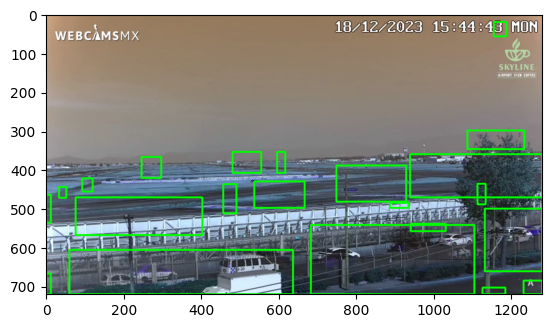

In [19]:
def procesar_frames(frame1, frame2):
    flow = compute_flow(frame1, frame2)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    rgb = get_flow_viz(flow)
    motion_thresh = np.c_[np.linspace(0.3, 1, frame1.shape[0])].repeat(frame1.shape[1], axis=-1)
    mask = get_motion_mask(mag, motion_thresh=motion_thresh)
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    detections = get_contour_detections_2(frame2, mask, ang, angle_thresh=2, thresh=400)
    bboxes = detections[:, :4]
    scores = detections[:, -1]
    for box in bboxes:
        x1,y1,x2,y2 = box
        cv2.rectangle(mask_rgb, (x1,y1), (x2,y2), (255,0,0), 3)
    #mask_rgb
    nms_bboxes = non_max_suppression(bboxes, scores, threshold=0.3)
    len(bboxes), len(nms_bboxes)
    mask_rgb_detections = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    for det in nms_bboxes:
        x1, y1, x2, y2 = det
        cv2.rectangle(mask_rgb_detections, (x1, y1), (x2, y2), (255, 0, 0), 3)
    draw_bboxes(frame2, nms_bboxes)
    plt.imshow(frame2);
    return frame2

def main(video_path, output_video_path):
    cap = cv2.VideoCapture(video_path)

    # Asegúrate de que el video se haya abierto correctamente
    if not cap.isOpened():
        print("Error al abrir el video.")
        return

    # Obtiene las propiedades del video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Crea un objeto VideoWriter para guardar el nuevo video
    fps_deseado = 0.5
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps_deseado, (frame_width, frame_height))
    # Lee el primer frame
    ret, frame1 = cap.read()

    # Establece la frecuencia deseada (un frame por segundo)
    fps_deseado = 1

    while True:
        # Lee el siguiente frame
        ret, frame2 = cap.read()
        if not ret:
            break

        # Procesa los frames
        resultado = procesar_frames(frame1, frame2)

        # Guarda el resultado en el nuevo video
        out.write(resultado)

        # Actualiza el frame1 para el próximo ciclo
        frame1 = frame2

        # Salta frames para alcanzar la frecuencia deseada
        saltos = int(fps / fps_deseado)
        for _ in range(saltos - 1):
            cap.read()

    # Libera los objetos de captura y escritura de video
    cap.release()
    out.release()

    print(f"Video procesado y guardado en {output_video_path}.")

# Ruta del video de entrada
video_path = 'aeropuerto2 .mp4'  # Reemplaza con la ruta de tu video

# Ruta del video de salida
output_video_path = 'resultado.mp4'

# Llama a la función principal para procesar los frames y guardar el nuevo video
main(video_path, output_video_path)